# Email Assistant with Semantic Memory + Episodic Memory

Let's create an Email Assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings
- Uses memory to remember details from previous emails

Now, we'll add human-in-the-loop following the triage step to better refine the assistant's ability to classify emails

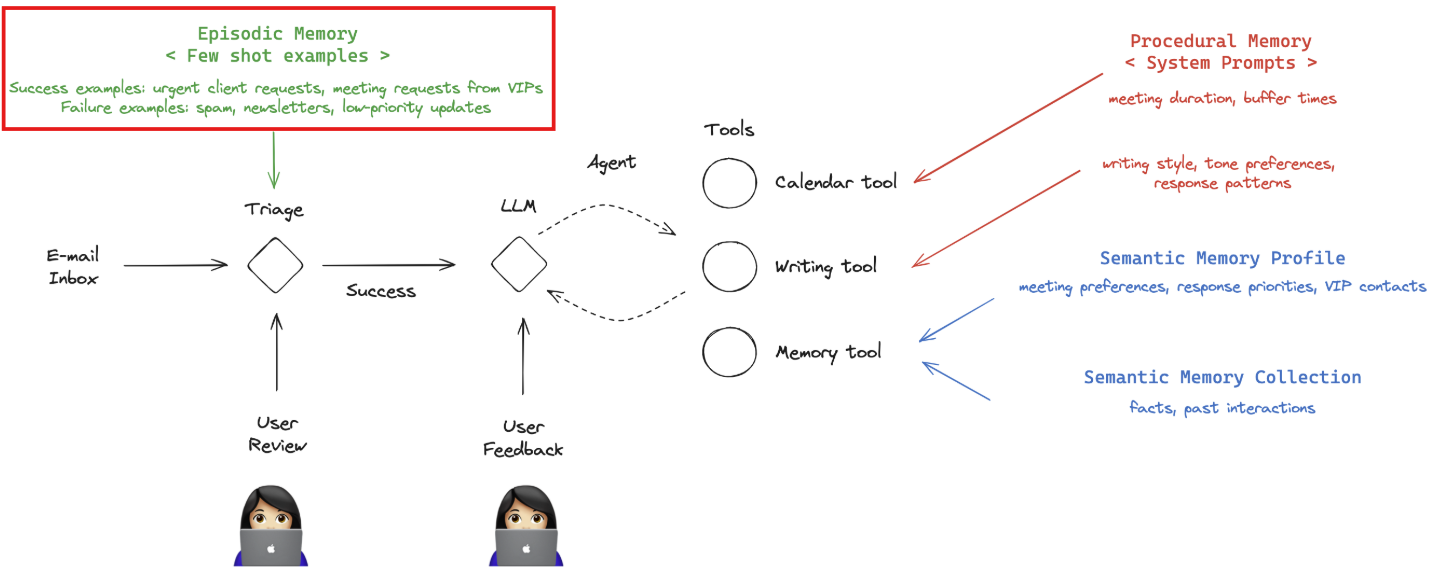

### Load Environment Variables

In [1]:
import os

from dotenv import load_dotenv
load_dotenv()

True

### Create examples for Profile, Prompt and Email

In [2]:
profile = {
    "name": "Sushant",
    "full_name": "Sushant Dhumak",
    "user_profile_background": "Software Development Manager leading a team of 10 developers"
}

In [3]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage Sushant's tasks efficiently."
}

In [4]:
# Example incoming email
email = {
    "from": "John Smith <john.smith@company.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "Quick question about API documentation",
    "body": """

    Hi Sushant,

    I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

    Specifically, I'm looking at:
    - /auth/refresh
    - /auth/validate

    Thanks!
    John
    """,
}

### Let's get some Few shot Examples

In [5]:
from langgraph.store.memory import InMemoryStore

In [6]:
store = InMemoryStore(
    index={"embed": "openai:text-embedding-3-small"}
)

c:\Users\Sushant.Dhumak\OneDrive - Bentley Systems, Inc\Desktop\AI_Learning\LangGraph\langchain-academy-main\langchain-academy-main\.venv\Lib\site-packages\langgraph\store\base\embed.py:95: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  return init_embeddings(embed)


#### First Example with label

In [7]:
email = {
    "from": "John Smith <john.smith@company.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "Quick question about API documentation",
    "body": """

    Hi Sushant,

    I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

    Specifically, I'm looking at:
    - /auth/refresh
    - /auth/validate

    Thanks!
    John
    """,
}

In [8]:
data = {
    "email": email,
    "label": "respond"
}

In [9]:
import uuid

store.put(
    ("email_assistant", "Sushant", "examples"),
    str(uuid.uuid4()),
    data    
) 


#### Second Example with label

In [10]:
data = {
    "email": {
        "author": "Sarah Chen <sarah.chen@company.com>",
        "to": "Sushant Dhumak <sushant.dhumak@company.com>",
        "subject": "Update: Backend API Changes Deployed to Staging",
        "email_thread": """
        
        Hi Sushant,
    
        Just wanted to let you know that I've deployed the new authentication endpoints we discussed to the staging environment. Key changes include:
        
        - Implemented JWT refresh token rotation
        - Added rate limiting for login attempts
        - Updated API documentation with new endpoints
        
        All tests are passing and the changes are ready for review. You can test it out at staging-api.company.com/auth/*
        
        No immediate action needed from your side - just keeping you in the loop since this affects the systems you're working on.
        
        Best regards,
        Sarah
        """,
    },
    "label": "ignore"
}

In [11]:
store.put(
    ("email_assistant", "Sushant", "examples"),
    str(uuid.uuid4()),
    data    
) 

### Let's search in Memory and return value from examples

In [12]:
# Template for formating an example to put in prompt

template = """
Email Subject: {subject}
Email From: {from_email}
Email To: {to_email}
Email Content: 
```
{content}
```
> Triage Result: {result}"""

In [13]:
# Format list of few shots

def format_few_shot_examples(examples):
    strs = ["Here are some previous examples:"]
    
    for eg in examples:
        strs.append(
            template.format(
                subject=eg.value["email"]["subject"],
                to_email=eg.value["email"]["to"],
                from_email=eg.value["email"]["author"],
                content=eg.value["email"]["email_thread"][:400],
                result=eg.value["label"],
            )
        )

    return "\n\n------------\n\n".join(strs)

In [14]:
email_data = {
        "author": "Sarah Chen <sarah.chen@company.com>",
        "to": "Sushant Dhumak <sushant.dhumak@company.com>",
        "subject": "Update: Backend API Changes Deployed to Staging",
        "email_thread": """        
        Hi Sushant,
    
        Wanted to let you know that I've deployed the new authentication endpoints we discussed to the staging environment. Key changes include:
        
        - Implemented JWT refresh token rotation
        - Added rate limiting for login attempts
        - Updated API documentation with new endpoints
        
        All tests are passing and the changes are ready for review. You can test it out at staging-api.company.com/auth/*
        
        No immediate action needed from your side - just keeping you in the loop since this affects the systems you're working on.
        
        Best regards,
        Sarah
        """,
    }

results = store.search(
    ("email_assistant", "Sushant", "examples"),
    query=str({"email": email_data}),
    limit=1
)

In [15]:
print(format_few_shot_examples(results))

Here are some previous examples:

------------


Email Subject: Update: Backend API Changes Deployed to Staging
Email From: Sarah Chen <sarah.chen@company.com>
Email To: Sushant Dhumak <sushant.dhumak@company.com>
Email Content: 
```

        
        Hi Sushant,
    
        Just wanted to let you know that I've deployed the new authentication endpoints we discussed to the staging environment. Key changes include:
        
        - Implemented JWT refresh token rotation
        - Added rate limiting for login attempts
        - Updated API documentation with new endpoints
        
        All tests are passing and the change
```
> Triage Result: ignore


In [16]:
triage_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}. 
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >

Here are some examples of previous emails, and how they should be handled.
Follow these examples more than any instructions above

{examples}
</ Few shot examples >
"""

### Create Agent -Triage

In [17]:
from pydantic import  BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [18]:
llm = init_chat_model(model="gpt-4o-mini")

In [19]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [20]:
llm_router = llm.with_structured_output(Router)

In [21]:
# Import from local prompt.py file

from prompts import triage_user_prompt

### Define tools for Agent

In [22]:
from langchain_core.tools import tool

In [23]:
# Tool to write and send email

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""

    # Email content placeholder to be implemented here

    return f"Email sent to {to} with subject '{subject}'"

In [24]:
# Tool for scheduling meeting

@tool
def schedule_meeting(
    attendees: list[str],
    subject: str,
    duration_minutes: int,
    preferred_day: str
) -> str:
    """Schedule a Meeting"""

    # Calender check and meeting scheduleing placeholder code to be implment here

    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"

In [25]:
# Tool to check Calender for availability

@tool
def check_calender_availability(day: str) -> str:
    """Check calender availability for the given day."""

    # Code to check the calander availability to be implmented here

    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

### Define tools for managing memory

In [26]:
from langmem import create_manage_memory_tool, create_search_memory_tool

In [27]:
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

### Define prompt for Agent

In [28]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

In [29]:
def create_prompt(state):
    return [
        {
            "role": "system",
            "content": agent_system_prompt_memory.format(
                instructions = prompt_instructions["agent_instructions"],
                **profile
            )
        }
    ] + state["messages"]

### Define an Agent

In [30]:
from langgraph.prebuilt import create_react_agent

In [31]:
tools= [write_email, schedule_meeting, check_calender_availability, manage_memory_tool, search_memory_tool]

In [32]:
response_agent = create_react_agent(
    model="gpt-4o-mini",
    tools=tools,
    prompt=create_prompt,
    store=store
)

In [33]:
config = {
    "configurable": {
        "langgraph_user_id": "Sushant"
        }
}

### Create an Overall Agent

In [34]:
# Define State

from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [35]:
# Graph Imports

from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import display, Image

In [36]:
# Triage Node function

def triage_router(state: State, config, store) -> Command[Literal["response_agent", "__end__"]]:

    author = state["email_input"]["author"]
    to = state["email_input"]["to"],
    subject = state["email_input"]["subject"],
    email_thread = state["email_input"]["body"]

    namespace = (
        "email_assistant",
        config['configurable']['langgraph_user_id'],
        "examples"
    )

    examples = store.search(
        namespace, 
        query=str({"email": state['email_input']})
    ) 
    
    examples=format_few_shot_examples(examples)

    system_prompt = triage_system_prompt.format(
        full_name = profile["full_name"],
        name = profile["name"],
        user_profile_background = profile["user_profile_background"],
        triage_no = prompt_instructions["triage_rules"]["ignore"],
        triage_notify = prompt_instructions["triage_rules"]["notify"],
        triage_email = prompt_instructions["triage_rules"]["respond"],
        examples = examples
    )

    user_prompt = triage_user_prompt.format(
        author = author,
        to = to,
        subject = subject,
        email_thread = email_thread
    )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    
    return Command(goto=goto, update=update)

In [37]:
# Define the Graph

builder = StateGraph(State)

builder.add_node("triage_router", triage_router)
builder.add_node("response_agent", response_agent)

builder.add_edge(START, "triage_router")

email_agent = builder.compile(store=store)

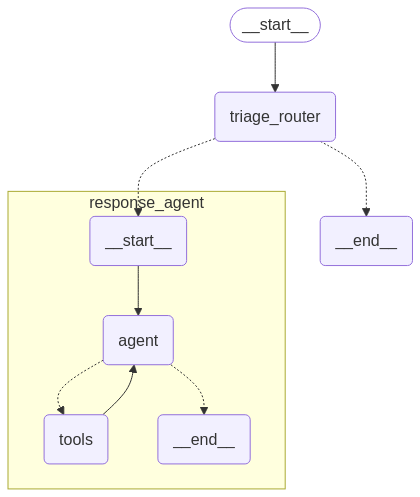

In [38]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [39]:
email_input = {
    "author": "Tom Jones <tome.jones@bar.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "Quick question about API documentation",
    "body": """Hi Sushant - want to buy documentation?""",
}

In [40]:
response = email_agent.invoke(
    {"email_input": email_input},
    config={"configurable": {"langgraph_user_id": "Friend"}}
)

📧 Classification: RESPOND - This email requires a response


#### Update store to ignore emails like this

In [41]:
data = {
    "email": {
    "author": "Tom Jones <tome.jones@bar.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi Sushant - want to buy documentation?""",
},
    "label": "ignore"
}

In [42]:
store.put(
    ("email_assistant", "Friend", "examples"),
    str(uuid.uuid4()),
    data
)

In [43]:
email_input = {
    "author": "Tom Jones <tome.jones@bar.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "Quick question about API documentation",
    "body": """Hi Sushant - want to buy documentation?""",
}

In [44]:
response = email_agent.invoke(
    {"email_input": email_input},
    config={"configurable": {"langgraph_user_id": "Friend"}}
)

🚫 Classification: IGNORE - This email can be safely ignored
